## **Step 1 - keywords Extraction**
***

We have two datasets, one with dream text descriptions:

In [ ]:
from keyword_extractor import read_datasets, extract_and_save_keywords_from_dataframes
from yaml_parser import load_config
config = load_config()
dream_df, keywords_df = read_datasets(config)
dream_df.head()

And another one with interpretations of dreams according to keywords:

In [ ]:
keywords_df

Then, we used a pretrained Sentence transformer to encode the dream embeddings and keyword embeddings and try to extract the most significant keywords from each dream.

### **all-MiniLM-L6-v2**
***

In [ ]:
dream_df = extract_and_save_keywords_from_dataframes()
dream_df

To view the dataframe better, We will filter out the interesting columns:

In [ ]:
columns_to_show = ['text_dream', 'Dream Symbol']
dream_df[columns_to_show]

## Step 2 - Summarize interpretations

After extracting the meaningful keywords, we tried to fetch the matching interpretation for each extracted keyword and use a pretrained LLM to summarize these interpretations into one interpretation.

### Load data and prepare (small) dataset for experimenting

In [1]:
import pandas as pd
import pandasql as ps
from plotly import express as px
from datetime import datetime
from transformers import pipeline
from utils import  release_all_gpu_memory, save_df_as_pretty_html
from summarizer import load_causal_model, batch_generate_interpretations
import torch


In [2]:
#dataset.to_csv("datasets/prepared_dataset.csv", index=False)
dataset = pd.read_csv("datasets/prepared_dataset.csv")

In [3]:

dataset.sort_values("input_tokens_len", ascending=False, inplace=True)

In [4]:
# filter dataset only to inputs of size that we can handle
dataset = dataset[dataset["input_tokens_len"] <500]

In [5]:
dataset

,prompt,dream,symbols,input,len,input_tokens_len,hash
20068,"Given dream description, interpret the meaning...",I was in some kind of pageant or play in an au...,- Fictional Character: To see a fictional ch...,"### Instruction:\nGiven dream description, int...",2218,499,af7b0dd9a0292eeb01b914f8725ca02f
14520,"Given dream description, interpret the meaning...",Will To Control I'm flying. I jump and soar h...,- Jumping: To dream that you are jumping ind...,"### Instruction:\nGiven dream description, int...",2116,499,4f29185c0930f39bb3fef9aa602a1cff
10985,"Given dream description, interpret the meaning...",I was watching a movie like Scary Movie. The g...,- Gender: To dream about your gender indicat...,"### Instruction:\nGiven dream description, int...",2191,499,adcc98e4e472558a12fc70e1022cba90
2490,"Given dream description, interpret the meaning...",I am a doctor/physical therapist and work with...,- Malpractice: To dream that you are sued fo...,"### Instruction:\nGiven dream description, int...",2126,499,b0f133c2d91c124cbca7d84611a70669
11027,"Given dream description, interpret the meaning...",It was Battlestar Galactica like. There was a ...,- Galaxy: To see the galaxy in your dream re...,"### Instruction:\nGiven dream description, int...",2176,499,43a96e111cb54e9c6abff7ef46803f79
...,...,...,...,...,...,...,...
7522,"Given dream description, interpret the meaning...",I was doing something that kind of reminded me...,- Geometry: To dream about geometry refers t...,"### Instruction:\nGiven dream description, int...",1480,332,90068fb36664db4f09612b620c5e5c34
14938,"Given dream description, interpret the meaning...",I had a dream about being in a band that plays...,- Band: To see a band or play with a band in...,"### Instruction:\nGiven dream description, int...",1403,330,20f414f3e2a888013ad52f5ac133a9d4
19889,"Given dream description, interpret the meaning...","In a room filled with people, they were awardi...",- Cabaret: To watch a cabaret in your dream ...,"### Instruction:\nGiven dream description, int...",1370,329,7e2c22c137f290a3489a2d05f8e1bbec
3572,"Given dream description, interpret the meaning...",A cat is sick and very tired. Then it dies. Th...,- Dachshund: To see a Dachshund in your drea...,"### Instruction:\nGiven dream description, int...",1338,324,69db6fb6dcffbe5d199364e10b55a34d


Now, we will create a prompt for the LLM. The prompt will include a request for the LLM to summarize the interpretations. It will get the dream description, the keywords, and the interpretations.

### Summarize with flan-T5-large model

In [18]:
release_all_gpu_memory()

['model', 'tokenizer', 'text2text_generator']
['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'release_all_gpu_memory', 'globals_snapshot', 'save_df_as_pretty_html', 'read_csvs']
clearing cuda cache
clearing ipc cache
✅ All GPU memory cleared.


In [7]:
# Step 1: Load FLAN-T5 model and tokenizer
model_name = "google/flan-t5-large"
model_name_short = model_name.split("/")[-1]
device = 0 if torch.cuda.is_available() else -1
model, tokenizer = load_causal_model(model_name)

In [8]:
text2text_generator = pipeline(
        "text2text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=1024,           # ✅ allow longer input
        truncation=True,           # ✅ ensure truncation at tokenizer level
        device=device,
    )

Device set to use cuda:0


Create interpretations in batches:

In [10]:
tstp = datetime.now().strftime(r"%y.%m.%d-%H")
result_df = batch_generate_interpretations(dataset, text2text_generator, input_column="input",
                                           batch_size=100, save_dir = "output/FlanT5")


✅ Already processed: 12 / 3674 entries


Generating batches:   0%|          | 0/37 [00:00<?, ?it/s]

Generating batches: 100%|██████████| 37/37 [3:19:48<00:00, 324.02s/it]  

🏁 Batch generation complete.


In [11]:
result_df

In [ ]:
postproc = lambda out: out["generated_text"].strip()
result_df["interpretation"] = result_df["interpretation"].apply(postproc)


In [ ]:
result_df

In [ ]:
result_df.columns

We saw that the interpretations are not quite good, and not that related to the dream description. We tried to save the dataframe for further research and saw that the problem applies to many cells and tried another model called Mistral.

In [ ]:
save_df = result_df[['prompt', 'symbols','dream', 'interpretation']]

path = f"output/{model_name_short}_{tstp}"

save_df_as_pretty_html(save_df, path + ".html")

save_df.to_csv(path + ".csv", index = False)

In [ ]:
result_df.interpretation.str.len()  # TODO: Remember why we sorted interpretations by length...

### Summarize with Mistral model

In [ ]:
from summarizer import load_mistral_4bit_model, find_max_batch_size
print("Loading Mistral-7B-Instruct in 4-bit...")
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_name_short = model_name.split("/")[-1]

model_family="decoder"

# max_new_tokens=256         max_new_tokens=max_new_tokens,


#### measure maximum batch size a given machine can hadle without OOMing


In [ ]:
sample_prompt = dataset.input[0]
print(f"Sample prompt length (characters): {len(sample_prompt)}")
model, tokenizer = load_mistral_4bit_model(model_name)
optimal_batch_size = find_max_batch_size(model, tokenizer, sample_prompt, max_possible=2048, max_new_tokens=512, ) # TODO: measure with max_new_tokens

first run on 24 Gb GPU: 
```
Sample prompt length (characters): 2437  
Trying batch_size = 512... ❌ OOM  
Trying batch_size = 256... ❌ OOM  
Trying batch_size = 128... ❌ OOM  
Trying batch_size = 64... ❌ OOM  
Trying batch_size = 32... ✅ success  
Trying batch_size = 48... ✅ success  
Trying batch_size = 56... ✅ success  
Trying batch_size = 60... ❌ OOM  
Trying batch_size = 58... ❌ OOM  
Trying batch_size = 57... ✅ success  

✅ Optimal batch size: 57
```

In [ ]:
# Clear memory after benchmarking
release_all_gpu_memory(["model","model_pipeline","dataloader"])

### Run the pipeline on the whole dataset

In [ ]:
optimal_batch_size = 40

def build_pipeline(model_name, batch_size, ):
    model, tokenizer = load_mistral_4bit_model(model_name)
    model_pipeline = pipeline(
            "text-generation",
            model=model,
            batch_size=batch_size,
            tokenizer=tokenizer,
            #max_length=1024,  
            max_new_tokens=512,         # ✅ controls output size
            truncation=True,            # ✅ safely truncates long inputs
            return_full_text=False,     # ✅ excludes input from output
            do_sample=False
        )
    return model_pipeline

model_pipeline = build_pipeline(model_name, optimal_batch_size)

In [ ]:
# Use this cell to re-import a function in case you've updated it's code in summarizer.py
from importlib import reload
import summarizer
reload(summarizer)

# Now re-import manually
from summarizer import batch_generate_interpretations


In [ ]:

print("\n🧠 Running interpretations...")
tstp = datetime.now().strftime(r"%y.%m.%d-%H")

batch_generate_interpretations(dataset, model_pipeline, save_dir="output/Mistral",
                               input_column="input", output_column="interpretation", 
                               batch_size=optimal_batch_size)
#print(result_df[["dream", "interpretation"]])


# Memory investigation

In [ ]:
from utils import globals_snapshot

tps = globals_snapshot()

q = """
select type, count(var) as cnt
from tps
group by type 
order by cnt desc 

"""
df = ps.sqldf(q)
df

It didn't seem to help... So we then tried to improve our keyword extraction using:
1. First - semantic search to narrow down the search of the keywords to only the semantically close ones.
2. Second - MMR (Maximal Marginal Relevance) to increase the diversity of keywords extracted from the dream.

#TODO: Summarize better_keywords_extraction.ipynb

## **Evaluation**
***

We evaluated the performance of the dream interpretation using BLEU,perplexity,ROUGE, and BERT. **It's important to mention: evaluation was tested on a small sample of 5 rows, and also the dream interpretation was compared to the dream itself and that might be the reason for the small values of the metrics**

### Flan-T5

In [12]:
from evaluation import evaluate_dream_interpretations
from utils import read_csvs
from summarizer import PromptFormatter
model_family="encoder"

formatter = PromptFormatter(model_family)

In [15]:
dataset = read_csvs(save_dir = "output/FlanT5")
dataset["meaning"] = dataset.interpretation.apply(formatter.unformat)
dataset = dataset[["dream", "symbols", "meaning"]]
dataset

,dream,symbols,meaning
0,I was at this place and everyone from school w...,- Ghost: To see a ghost in your dream repres...,Everyone from school was there. There was a gh...
1,"A LT event of some sort, in a small school aud...",- Baby Shower: To dream of a baby shower sug...,"LT event of some sort, in a small school audit..."
2,Looking across I see mother in a window whippi...,- Baby Carriage: To see a baby carriage in y...,A mother is whipping her son.
3,I was lacing my shoes and my shoestrings were ...,- Barbed Wire: To see barbed wire in your dr...,The dreamer is lacing his shoes and his shoest...
4,"I was playing soccer on a huge field, and the ...",- Ball: To see or play with a ball in your d...,The dreamer is playing soccer on a huge field.
...,...,...,...
95,I see that I am in the university yard and see...,- Abscess: To dream that you have an abscess...,Abscess: To dream that you have an abscess sug...
96,I was at this place that we went to regularly....,- Koala: To see a koala in your dream repres...,The dreamer is a snake.
97,I dreamed I was playing the guitar with a frie...,- Band: To see a band or play with a band in...,A friend is learning how to play the guitar. T...
98,Meat: $27 Per Pound I'm at Cub Foods shopping...,- Ham: To dream that you are eating ham indi...,A man wants some meat that costs $27 per pound...


In [16]:
dreams_interpretations_df = evaluate_dream_interpretations(dataset, interpretation_column = 'meaning')
dreams_interpretations_df.to_csv('datasets/flan-t5-large_evaluated.csv', index=False)


/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Con

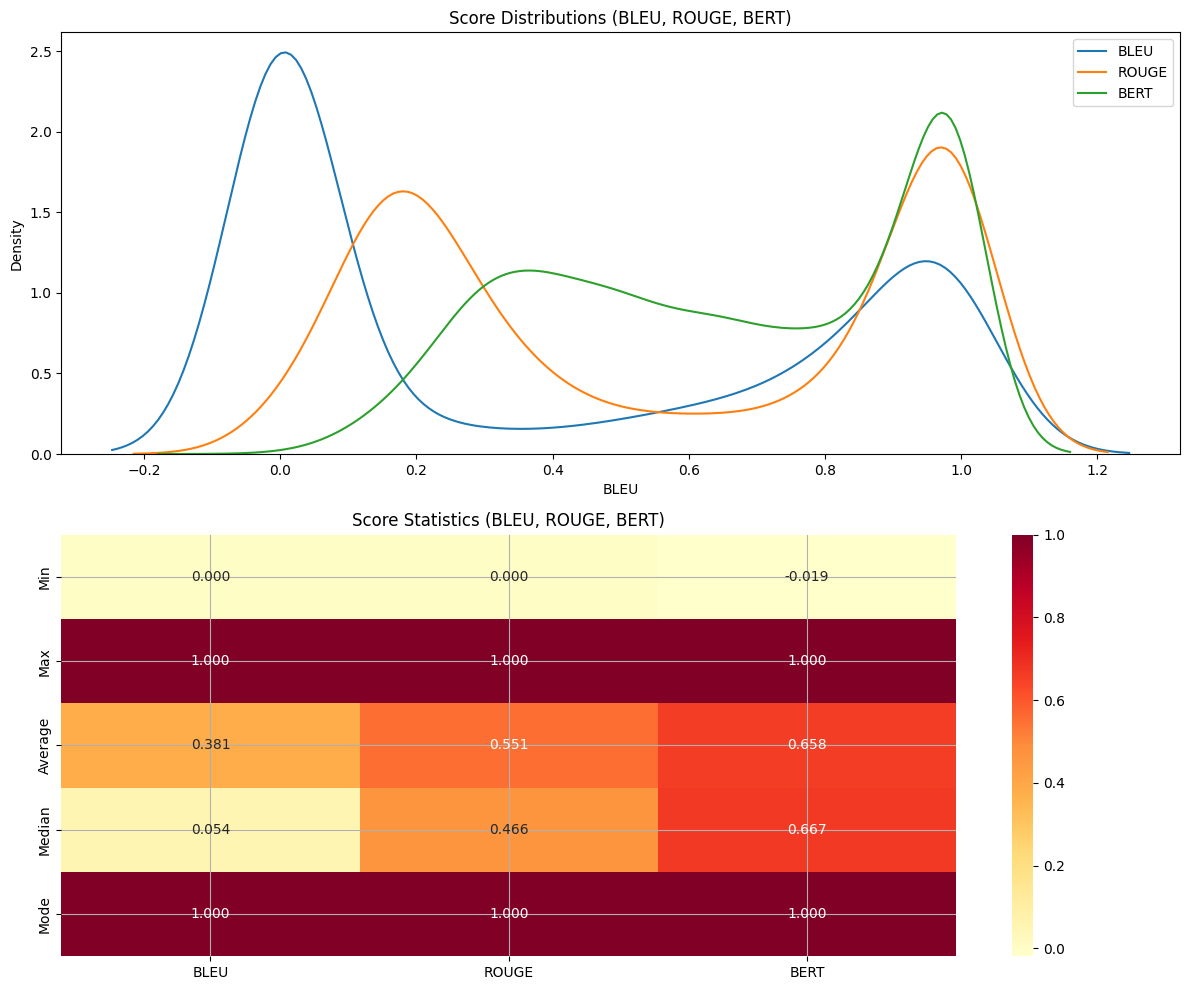

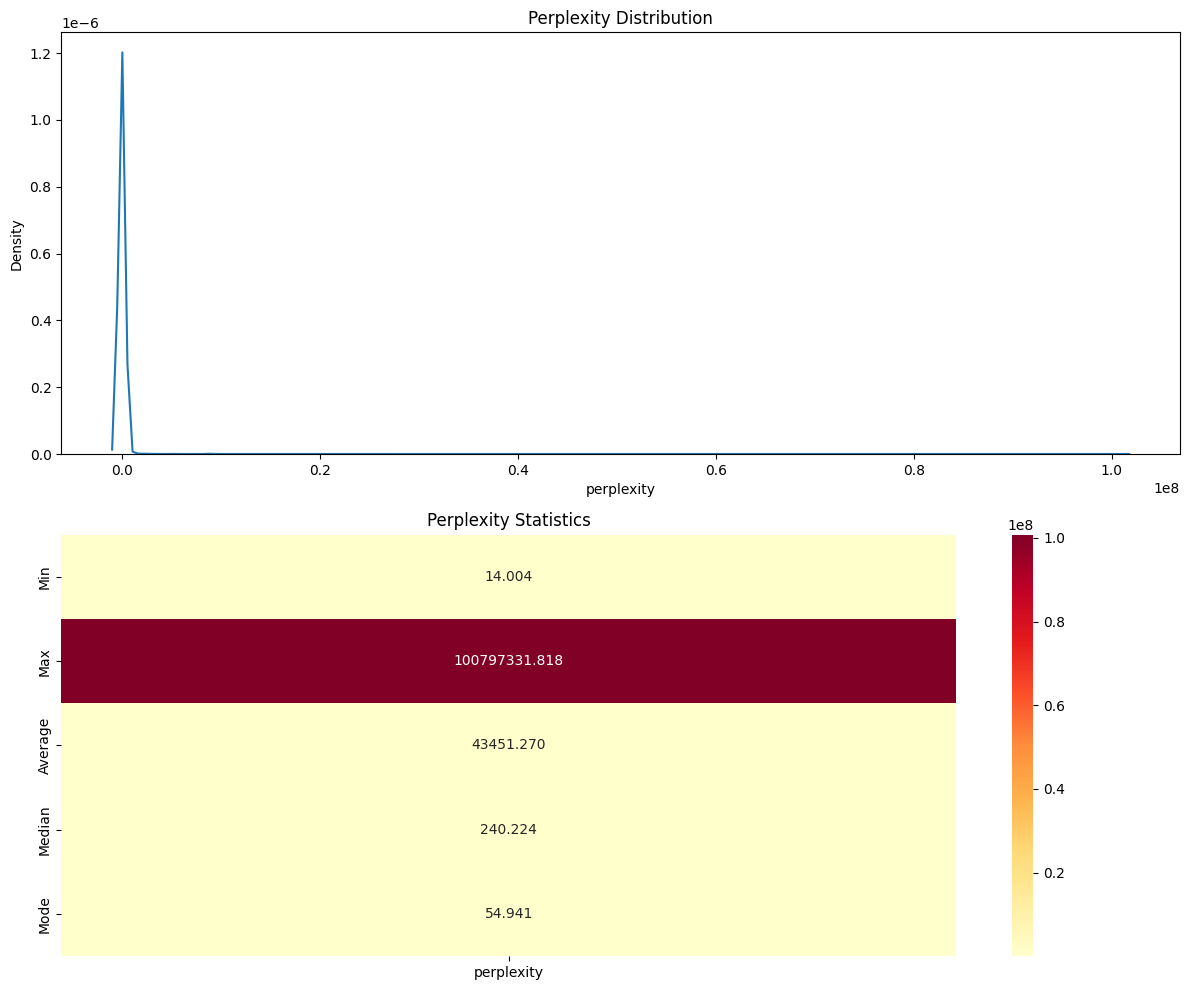

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create figure with subplots for non-perplexity scores
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plt.grid()

# Plot distributions without perplexity
scores_without_perplexity = ['BLEU', 'ROUGE', 'BERT']
for score in scores_without_perplexity:
    sns.kdeplot(data=dreams_interpretations_df[score], label=score, ax=ax1)
ax1.set_title('Score Distributions (BLEU, ROUGE, BERT)')
ax1.legend()

# Calculate statistics for heatmap without perplexity
stats_df = pd.DataFrame()
for score in scores_without_perplexity:
    stats_df[score] = [
        dreams_interpretations_df[score].min(),
        dreams_interpretations_df[score].max(),
        dreams_interpretations_df[score].mean(),
        dreams_interpretations_df[score].median(),
        stats.mode(dreams_interpretations_df[score])[0]
    ]
stats_df.index = ['Min', 'Max', 'Average', 'Median', 'Mode']

# Plot heatmap
sns.heatmap(stats_df, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2)
ax2.set_title('Score Statistics (BLEU, ROUGE, BERT)')
plt.tight_layout()

# Create separate figure for perplexity
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(12, 10))

# Plot perplexity distribution
sns.kdeplot(data=dreams_interpretations_df['perplexity'], ax=ax3)
ax3.set_title('Perplexity Distribution')

# Calculate perplexity statistics
perplexity_stats = pd.DataFrame({
    'perplexity': [
        dreams_interpretations_df['perplexity'].min(),
        dreams_interpretations_df['perplexity'].max(),
        dreams_interpretations_df['perplexity'].mean(),
        dreams_interpretations_df['perplexity'].median(),
        stats.mode(dreams_interpretations_df['perplexity'])[0]
    ]
})
perplexity_stats.index = ['Min', 'Max', 'Average', 'Median', 'Mode']

# Plot perplexity heatmap
sns.heatmap(perplexity_stats, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax4)
ax4.set_title('Perplexity Statistics')
plt.tight_layout()

plt.show()


### Mistral

In [11]:
from evaluation import evaluate_dream_interpretations
from utils import read_csvs
from summarizer import PromptFormatter
model_family="decoder"

formatter = PromptFormatter(model_family)

In [ ]:
dataset = read_csvs(save_dir = "output/Mistral")
dataset["meaning"] = dataset.interpretation.apply(formatter.unformat)
dataset = dataset[["dream", "symbols", "meaning"]]
dataset

,dream,symbols,meaning
0,I was with some friends on a street and we wer...,- Abduction: To dream of being abducted indi...,The dream starts with the dreamer and her frie...
1,"I liked this guy, though he was dating someone...",- Abduction: To dream of being abducted indi...,The dreamer is attracted to a man who is alrea...
2,I was in New York sitting in on a radio broadc...,- Camping: To dream that you are camping ind...,"The dreamer is in New York, which could repres..."
3,"I am traveling through the countryside, on the...",- Hamlet: To see Hamlet in your dream refers...,The dreamer is traveling through the countrysi...
4,Romeo and Juliet I'm in a room with my housem...,- Hamlet: To see Hamlet in your dream refers...,"The dreamer is in a room with two other men, o..."
...,...,...,...
35,The predominant background for the dreams prac...,- Hallucination: To have a hallucination in ...,"The dreamer describes a scene of inactivity, w..."
36,I was at university. It was Tuesday and I had ...,- Cafeteria: To dream that you are in a cafe...,"The dreamer is in a university setting, which ..."
37,I was in the passenger seat of my family's old...,- Abandonment: To dream that you are abandon...,The dream is about feeling abandoned and betra...
38,At a party of some kind I meet a girl known fr...,"- Kiss: To dream of a kiss denotes love, aff...",The dream is about unrequited love and insecur...


In [14]:
dreams_interpretations_df = evaluate_dream_interpretations(dataset, interpretation_column = 'meaning')
dreams_interpretations_df.to_csv('datasets/Mistral-7B-Instruct-v0.2_evaluated.csv', index=False)


/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ofirn/Dream-Interpreter/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Con

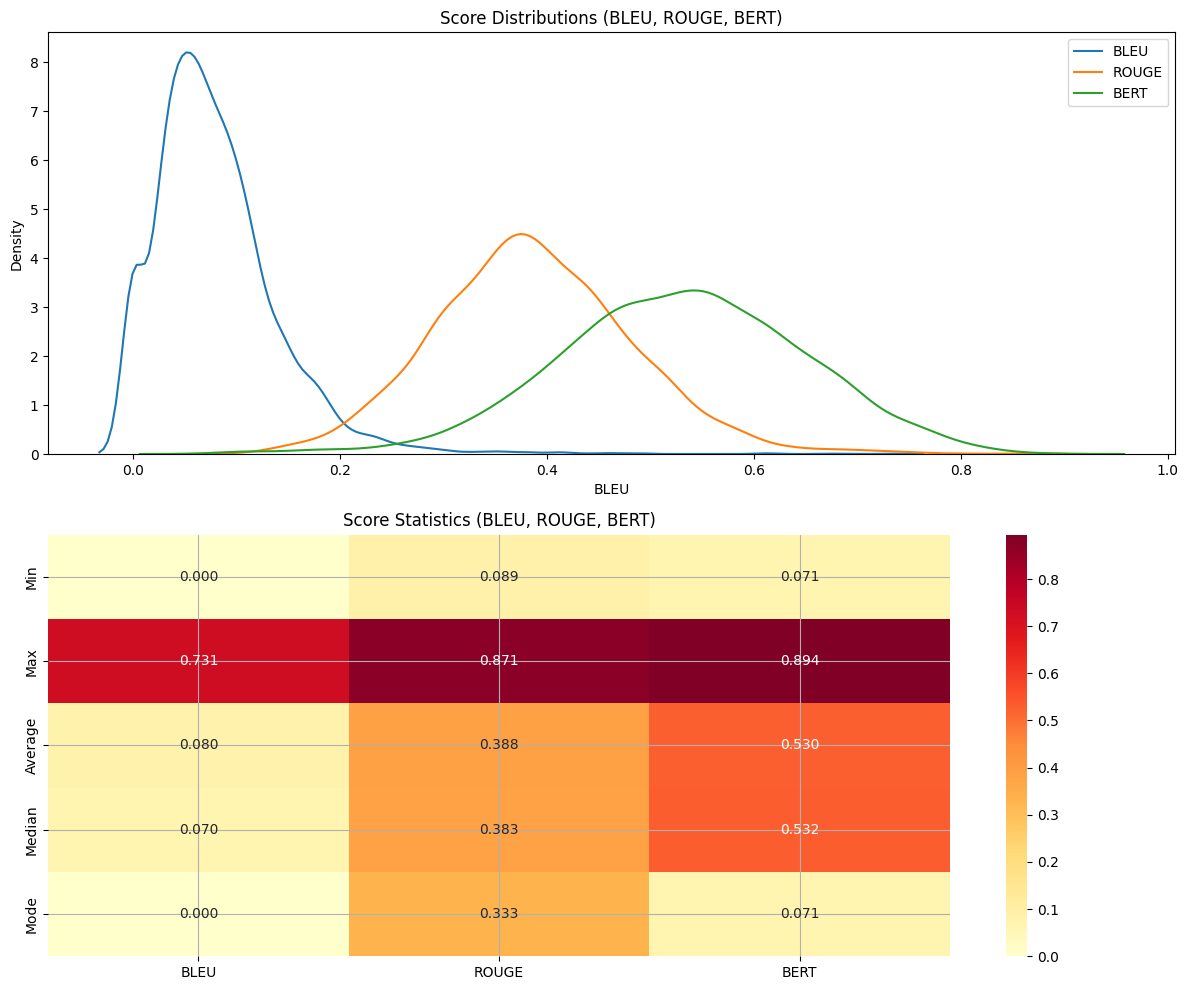

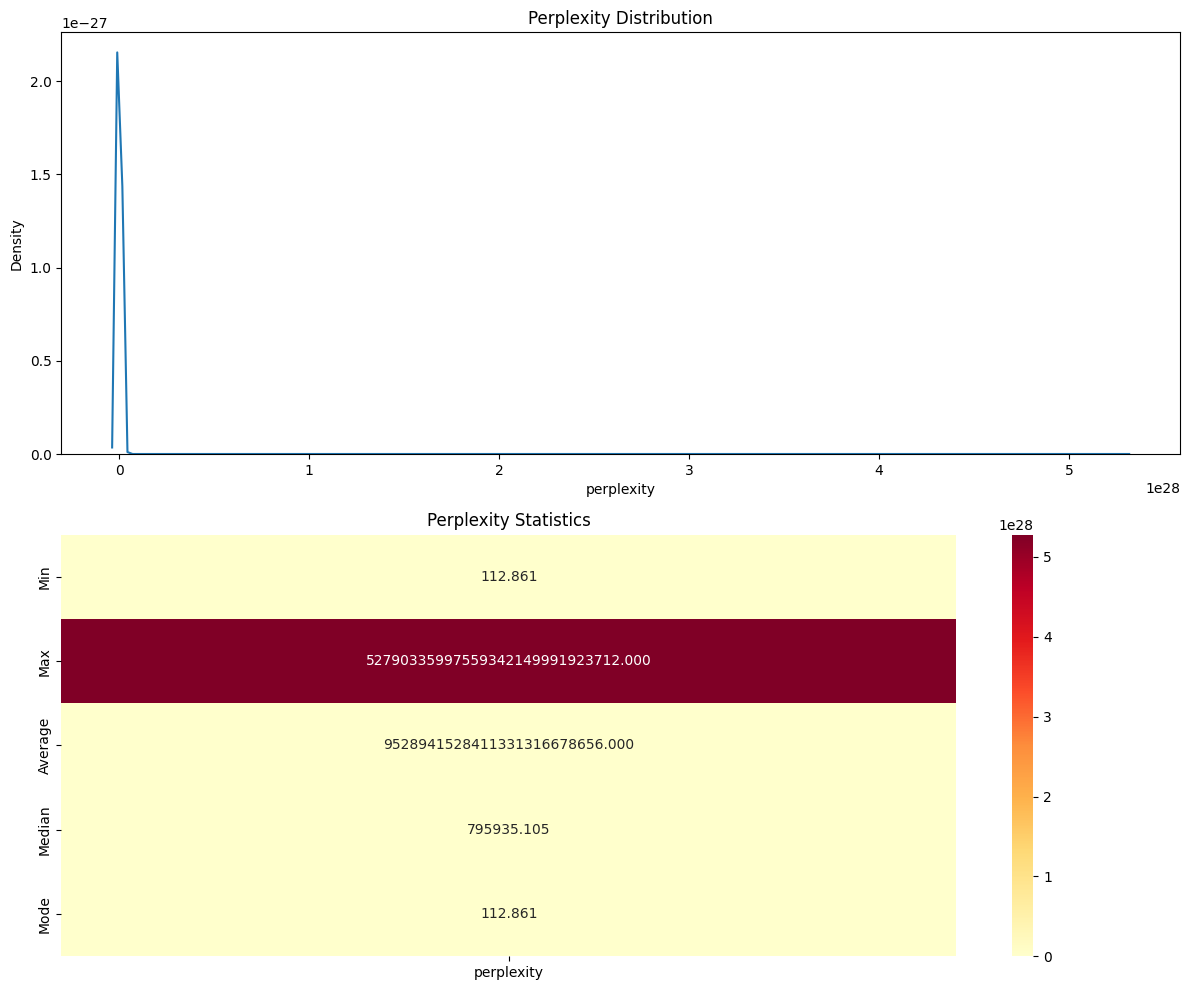

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create figure with subplots for non-perplexity scores
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plt.grid()

# Plot distributions without perplexity
scores_without_perplexity = ['BLEU', 'ROUGE', 'BERT']
for score in scores_without_perplexity:
    sns.kdeplot(data=dreams_interpretations_df[score], label=score, ax=ax1)
ax1.set_title('Score Distributions (BLEU, ROUGE, BERT)')
ax1.legend()

# Calculate statistics for heatmap without perplexity
stats_df = pd.DataFrame()
for score in scores_without_perplexity:
    stats_df[score] = [
        dreams_interpretations_df[score].min(),
        dreams_interpretations_df[score].max(),
        dreams_interpretations_df[score].mean(),
        dreams_interpretations_df[score].median(),
        stats.mode(dreams_interpretations_df[score])[0]
    ]
stats_df.index = ['Min', 'Max', 'Average', 'Median', 'Mode']

# Plot heatmap
sns.heatmap(stats_df, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2)
ax2.set_title('Score Statistics (BLEU, ROUGE, BERT)')
plt.tight_layout()

# Create separate figure for perplexity
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(12, 10))

# Plot perplexity distribution
sns.kdeplot(data=dreams_interpretations_df['perplexity'], ax=ax3)
ax3.set_title('Perplexity Distribution')

# Calculate perplexity statistics
perplexity_stats = pd.DataFrame({
    'perplexity': [
        dreams_interpretations_df['perplexity'].min(),
        dreams_interpretations_df['perplexity'].max(),
        dreams_interpretations_df['perplexity'].mean(),
        dreams_interpretations_df['perplexity'].median(),
        stats.mode(dreams_interpretations_df['perplexity'])[0]
    ]
})
perplexity_stats.index = ['Min', 'Max', 'Average', 'Median', 'Mode']

# Plot perplexity heatmap
sns.heatmap(perplexity_stats, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax4)
ax4.set_title('Perplexity Statistics')
plt.tight_layout()

plt.show()


We can draw the following conclusions:
1. The bleu score is incredibly low (a good result should be 20-40, we didn't even get 1...). This means that there is a weak overlap between the dream and its interpretation.
2. Same for the Rouge.
3. BERT averages at 0.6, which is not that bad considering that a good value is 0.85–0.9 that indicates some semantic similarity between the dream and its interpretation.
4. perplexity is terrible since a good value is under 20...
5. We interpret the results using this table:


| **Metric** | **High Score Meaning** | **Low Score Meaning** | **Preferred Score** | **Typical Values for Good Results** | **Why?** |
| --- | --- | --- | --- | --- | --- |
| **BLEU** | High n-gram overlap between reference and candidate text | Low n-gram overlap between reference and candidate text | **High** | 20–40 (moderate), 40+ (good) | High BLEU indicates the candidate text closely matches the reference text. |
| **Perplexity** | Candidate text is unpredictable and diverges from reference distribution | Candidate text is predictable, fluent, and aligned with reference distribution | **Low** | < 20 (for good results) | Low perplexity shows that the candidate text is fluent, consistent, and aligned with the reference. |
| **ROUGE** | More overlapping n-grams (e.g., unigrams, bigrams) and higher recall of key phrases | Fewer overlapping n-grams and poor recall of key phrases | **High** | 30–50 (good), 50+ (very good) | High ROUGE suggests greater similarity between the candidate and reference texts. |
| **BERTScore** | Strong semantic similarity between the candidate and reference text | Weak semantic similarity between the candidate and reference text | **High** | 0.85–0.98 (good) | Higher BERTScore reflects that the candidate preserves the meaning of the reference text. |

